#  Predict Future Sales - April 2019

### Problem statement

This challenge is about working with a time-series dataset provided by one of the largest Russian software firms. 

It consists of daily sales data, and the task is to predict total sales for every product and store in the next month. Note that the list of shops and products slightly changes every month, therefore creating a robust model that can handle such situations is part of the challenge. 

https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data

### Objective

In the Kaggle discussion section, participants were saying that the XGBOOST model was a better predictor for this competition. 

However, I just wanted to have play a bit with data using a LSTM model.

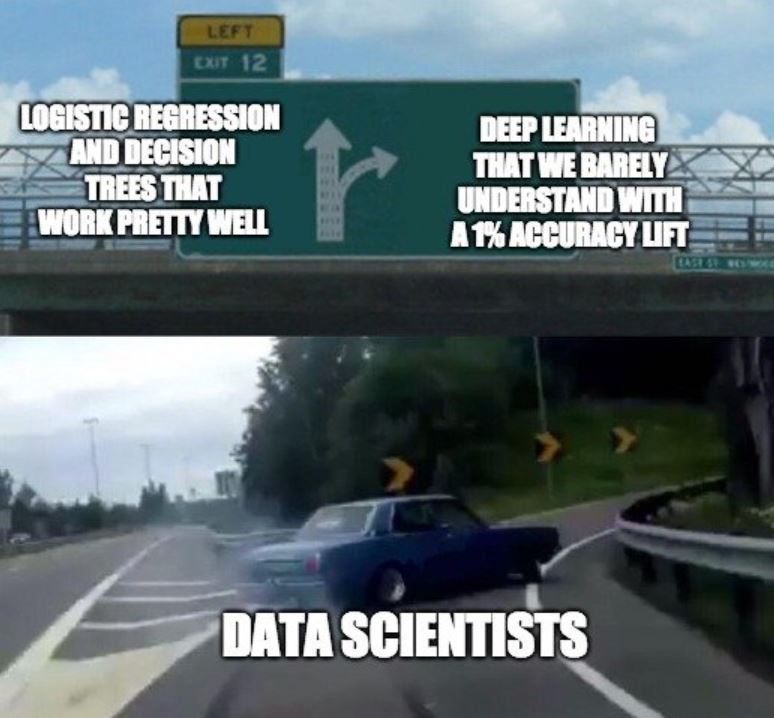

In [1]:
from IPython.display import Image
Image(filename='meme_car.jpg',width="350")

### Importing data

In [2]:
# importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import time
notebookstart= time.time()

In [3]:
# loading the data
df_train = pd.read_csv('sales_train.csv.gz', compression='gzip', error_bad_lines=False, parse_dates=['date']
                    , infer_datetime_format=True, dayfirst=True)
df_test = pd.read_csv('test.csv.gz', compression='gzip', error_bad_lines=False)
items = pd.read_csv("items.csv")
item_categories = pd.read_csv("item_categories.csv")
shops = pd.read_csv("shops.csv")

In [4]:
# Merging additional datasets
df_train_1 = df_train.merge(items, on='item_id')
df_train_2 = df_train_1.merge(item_categories, on='item_category_id')
train = df_train_2.merge(shops, on='shop_id')
print(train.shape)
train.head(3)

(2935849, 10)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,2013-01-02,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,2013-04-26,3,59,944,150.0,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
2,2013-06-26,5,59,944,199.5,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""


In [5]:
train.shape

(2935849, 10)

In [6]:
print('Min date',train.date.min())
print('Max date',train.date.max())

# train.set_index('date', inplace=True)
train.columns

Min date 2013-01-01 00:00:00
Max date 2015-10-31 00:00:00


Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_name', 'item_category_id', 'item_category_name',
       'shop_name'],
      dtype='object')

### Feature engineering

#### NAs imputation

In [7]:
features = train

nulls = np.sum(features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values.")

Empty DataFrame
Columns: [0, 1]
Index: []
There are 0 columns with missing values.


#### Selecting only shop_id and item_id present in the test set

In [8]:
test_shop_id = df_test['shop_id'].unique()
test_item_id = df_test['item_id'].unique()

features = train[train['shop_id'].isin(test_shop_id)]
features = train[train['item_id'].isin(test_item_id)]

features.shape

(1446006, 10)

#### Creating some features

In [9]:
features.loc[features['item_category_name'].str.contains("Кино"), 'Category2'] = 'Film'
features.loc[features['item_category_name'].str.contains("Blu-Ray"), 'Category2'] = 'Film'
features.loc[features['item_category_name'].str.contains("Музыка"), 'Category2'] = 'Music'
features.loc[features['item_category_name'].str.contains("MP3"), 'Category2'] = 'Music'
features.loc[features['item_category_name'].str.contains("Книги"), 'Category2'] = 'Books'
features.loc[features['item_category_name'].str.contains("Игры"), 'Category2'] = 'Games' 
features.loc[features['item_category_name'].str.contains("PS2"), 'Category2'] = 'Games'
features.loc[features['item_category_name'].str.contains("PS3"), 'Category2'] = 'Games'
features.loc[features['item_category_name'].str.contains("PS4"), 'Category2'] = 'Games'
features.loc[features['item_category_name'].str.contains("PSP"), 'Category2'] = 'Games'
features.loc[features['item_category_name'].str.contains("XBOX"), 'Category2'] = 'Games'
features.loc[features['item_category_name'].str.contains("Программы"), 'Category2'] = 'Programs'
features.loc[features['item_category_name'].str.contains("Подарки"), 'Category2'] = 'Gifts'
features.loc[features['item_category_name'].str.contains("Карты оплаты"), 'Category2'] = 'Payment cards'
features.loc[features['item_category_name'].str.contains("Аксессуары"), 'Category2'] = 'Accessories'

features.Category2.replace(np.nan, 'Other', regex=True, inplace = True)

C:\Users\lramp\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\lramp\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\lramp\Anaconda3\lib\site-packages\pandas\core\generic.py:6576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

In [10]:
features['shop_city'] = features['shop_name'].str.split(' ').map(lambda x: x[0])
features.loc[features.shop_city == '!Якутск', 'shop_city'] = 'Якутск'

C:\Users\lramp\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
features.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_name', 'item_category_id', 'item_category_name',
       'shop_name', 'Category2', 'shop_city'],
      dtype='object')

#### Dealing with outliers

In [12]:
features_outliers = features[['date_block_num','shop_id','item_id','item_price','item_cnt_day']]

from sklearn.neighbors import LocalOutlierFactor
detector = LocalOutlierFactor(n_neighbors=20, contamination=0.0005, n_jobs=3)
outliers_predictions = detector.fit_predict(features_outliers)

outliers = []
for index, value in enumerate(outliers_predictions):
     if value == -1:
        outliers.append(index)
print('number of outliers to remove:', len(outliers))
print(features_outliers.shape)
#print(y.shape)

number of outliers to remove: 724
(1446006, 5)


The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood.



After analyzing the selected outliers, it was clear that overpriced items were the main issue. I then decided to remove all items whose price was bigger than 1,100.

In [13]:
features = features[features.item_price<1100]

Similarly, I replace a some negative quantities by the median of quantities.

In [14]:
features.loc[features.item_cnt_day < 0, 'item_cnt_day'] = features['item_cnt_day'].median()
features.shape

(1052859, 12)

#### Grouping by month and combinaisons of shops-items

In [15]:
# create monthly data for the combinaison shop-item
df = features.groupby([features.date.apply(lambda x: x.strftime('%Y-%m')),'item_id','shop_id']).sum().reset_index()
df = df[['date', 'item_id', 'shop_id', 'date_block_num', 'item_cnt_day']]
df.to_csv('df_1.csv', index = False)

# getting the monthly avg item_price for each combinaison of shop-item
df_avg_item_price = features.groupby([features.date.apply(lambda x: x.strftime('%Y-%m')),'item_id','shop_id']
                                      , as_index=False).mean().reset_index()
df_avg_item_price = df_avg_item_price[['item_id', 'shop_id', 'date_block_num', 'item_price']]
df_avg_item_price.to_csv('df_2.csv', index = False)

# merging datasets
df_1 = pd.read_csv("df_1.csv")
df_2 = pd.read_csv("df_2.csv")
df_3 = pd.merge(df_1, df_2, on=['item_id','shop_id','date_block_num'], how='left')
df_3.head()

,date,item_id,shop_id,date_block_num,item_cnt_day,item_price
0,2013-01,32,0,0,6.0,221.0
1,2013-01,32,1,0,7.0,221.0
2,2013-01,32,3,0,3.0,349.0
3,2013-01,32,4,0,2.0,349.0
4,2013-01,32,6,0,8.0,349.0


#### Encoding categorical variables

In [16]:
from sklearn.preprocessing import LabelEncoder

features_2 = features[['date_block_num', 'shop_id', 'item_id', 'item_name', 'item_category_id', 'item_category_name'
                       , 'shop_name', 'Category2', 'shop_city']]

features_to_encode = ['item_name', 'item_category_name', 'shop_name', 'Category2', 'shop_city']

cols = features_to_encode
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(features_2[c].values)) 
    features_2[c] = lbl.transform(list(features_2[c].values))

df_4 = pd.merge(df_3, features_2, on=['item_id','shop_id','date_block_num'], how='left')
df_4.head(2)

C:\Users\lramp\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,date,item_id,shop_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,item_category_name,shop_name,Category2,shop_city
0,2013-01,32,0,0,6.0,221.0,2.0,40.0,24.0,0.0,2.0,29.0
1,2013-01,32,0,0,6.0,221.0,2.0,40.0,24.0,0.0,2.0,29.0


In [17]:
df_5 = df_4.pivot_table(index=['item_id','shop_id'], columns='date',values='item_cnt_day',fill_value=0).reset_index()

In [18]:
# Merge data from monthly sales to specific item-shops in test data
test = pd.merge(df_test,df_5,on=['item_id','shop_id'], how='left').fillna(0)

# Strip categorical data so keras only sees raw timeseries
test = test.drop(labels=['ID','item_id','shop_id'],axis=1)

#### Rescaling some numerical features

In [19]:
# Rearrange the raw data to be monthly average price by item-shop
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

df_train["item_price"] = scaler.fit_transform(df_train["item_price"].values.reshape(-1,1))
df2 = df_train.groupby([df_train.date.apply(lambda x: x.strftime('%Y-%m')),'item_id','shop_id']).mean().reset_index()
df2 = df2[['date','item_id','shop_id','item_price']].pivot_table(index=['item_id','shop_id'], columns='date',values='item_price',fill_value=0).reset_index()

#### Preprocessing data to RNN format

In [20]:
# Merge data from average prices to specific item-shops in test data
price = pd.merge(df_test,df2,on=['item_id','shop_id'], how='left').fillna(0)
price = price.drop(labels=['ID','item_id','shop_id'],axis=1)

In [21]:
# Create x and y training sets from oldest data points
y_train = test['2015-10']
x_sales = test.drop(labels=['2015-10'],axis=1)

In [22]:
import gc
x_sales = x_sales.values.reshape((x_sales.shape[0], x_sales.shape[1], 1))
x_prices = price.drop(labels=['2015-10'],axis=1)
x_prices= x_prices.values.reshape((x_prices.shape[0], x_prices.shape[1], 1))
X = np.append(x_sales,x_prices,axis=2)
y = y_train.values.reshape((214200, 1))
print("Training Predictor Shape: ",X.shape)
print("Training Predictee Shape: ",y.shape)
del y_train, x_sales; gc.collect()

Training Predictor Shape:  (214200, 33, 2)
Training Predictee Shape:  (214200, 1)


0

In [23]:
# Transform test set into numpy matrix
test = test.drop(labels=['2013-01'],axis=1)
x_test_sales = test.values.reshape((test.shape[0], test.shape[1], 1))
x_test_prices = price.drop(labels=['2013-01'],axis=1)
x_test_prices = x_test_prices.values.reshape((x_test_prices.shape[0], x_test_prices.shape[1], 1))

# Combine Price and Sales Df
test = np.append(x_test_sales,x_test_prices,axis=2)
del x_test_sales,x_test_prices, price; gc.collect()
print("Test Predictor Shape: ",test.shape)

Test Predictor Shape:  (214200, 33, 2)


#### Modelling

In [27]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, ThresholdedReLU, MaxPooling2D, Embedding, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

print("Modeling Stage")
# Define the model layers
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(X.shape[1], X.shape[2]),return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer="adam", loss='mse', metrics=["mse"])
print(model_lstm.summary())

Modeling Stage
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 33, 16)            1216      
_________________________________________________________________
dropout_3 (Dropout)          (None, 33, 16)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 7,521
Trainable params: 7,521
Non-trainable params: 0
_________________________________________________________________
None



Fit Model
X Train Shape:  (192780, 33, 2)
X Valid Shape:  (21420, 33, 2)
y Train Shape:  (192780, 1)
y Valid Shape:  (21420, 1)
Train on 192780 samples, validate on 21420 samples
Epoch 1/15
 - 46s - loss: 32.6549 - mean_squared_error: 32.6549 - val_loss: 0.8741 - val_mean_squared_error: 0.8741
Epoch 2/15
 - 45s - loss: 32.1770 - mean_squared_error: 32.1770 - val_loss: 0.8525 - val_mean_squared_error: 0.8525
Epoch 3/15
 - 45s - loss: 32.0766 - mean_squared_error: 32.0766 - val_loss: 0.8320 - val_mean_squared_error: 0.8320
Epoch 4/15
 - 43s - loss: 31.9292 - mean_squared_error: 31.9292 - val_loss: 0.8216 - val_mean_squared_error: 0.8216
Epoch 5/15
 - 43s - loss: 31.8936 - mean_squared_error: 31.8936 - val_loss: 0.7982 - val_mean_squared_error: 0.7982
Epoch 6/15
 - 44s - loss: 31.5546 - mean_squared_error: 31.5546 - val_loss: 0.7875 - val_mean_squared_error: 0.7875
Epoch 7/15
 - 45s - loss: 31.3415 - mean_squared_error: 31.3415 - val_loss: 0.7750 - val_mean_squared_error: 0.7750
Epoch 8/

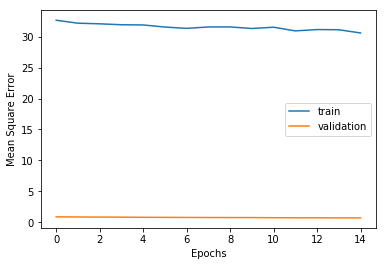

<Figure size 432x288 with 0 Axes>

In [28]:
# Train Model
print("\nFit Model")
VALID = True
LSTM_PARAM = {"batch_size":128,
              "verbose":2,
              "epochs":15}

modelstart = time.time()
if VALID is True:
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, random_state=1, shuffle=False)
    # del X,y; gc.collect()
    print("X Train Shape: ",X_train.shape)
    print("X Valid Shape: ",X_valid.shape)
    print("y Train Shape: ",y_train.shape)
    print("y Valid Shape: ",y_valid.shape)
    
    callbacks_list=[EarlyStopping(monitor="val_loss",min_delta=.001, patience=3,mode='auto')]
    hist = model_lstm.fit(X_train, y_train,
                          validation_data=(X_valid, y_valid),
                          callbacks=callbacks_list,
                          **LSTM_PARAM)
    pred = model_lstm.predict(test)
        # Model Evaluation
    best = np.argmin(hist.history["val_loss"])
    print("Optimal Epoch: {}",best)
    print("Train Score: {}, Validation Score: {}".format(hist.history["loss"][best],hist.history["val_loss"][best]))

    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='validation')
    plt.xlabel("Epochs")
    plt.ylabel("Mean Square Error")
    plt.legend()
    plt.show()
    plt.savefig("Train and Validation MSE Progression.png")

if VALID is False:
    print("X Shape: ",X.shape)
    print("y Shape: ",y.shape)
    hist = model_lstm.fit(X,y,**LSTM_PARAM)
    pred = model_lstm.predict(X)
    
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Mean Square Error")
    plt.legend()
    plt.show()
    plt.savefig("Training Loss Progression.png")

In [30]:
print("\Output Submission")
submission = pd.DataFrame(pred,columns=['item_cnt_month'])
submission.to_csv('submission1.csv',index_label='ID')
print(submission.head())

\Output Submission
   item_cnt_month
0        0.246309
1        0.075666
2        0.334865
3        0.144542
4        0.075666
